# Trabalho 2

Análise de Dados Espaciais - MapBiomas Uso e Cobertura do Solo

In [7]:
#Bibliotecas necessárias
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap


In [31]:
#Determinando os caminhos
#Arquivo uso do solo
usosolo=r'../dados_solo/brasil_coverage_2013.tif'
#Extraindo o ano do uso do solo do arquivo
ano = usosolo.split('_')[-1].split('.')[0]
#Arquivo com shape do local de interesse
shape=r'../dados_solo/bacia_ratones.shp'
print(ano)

2013


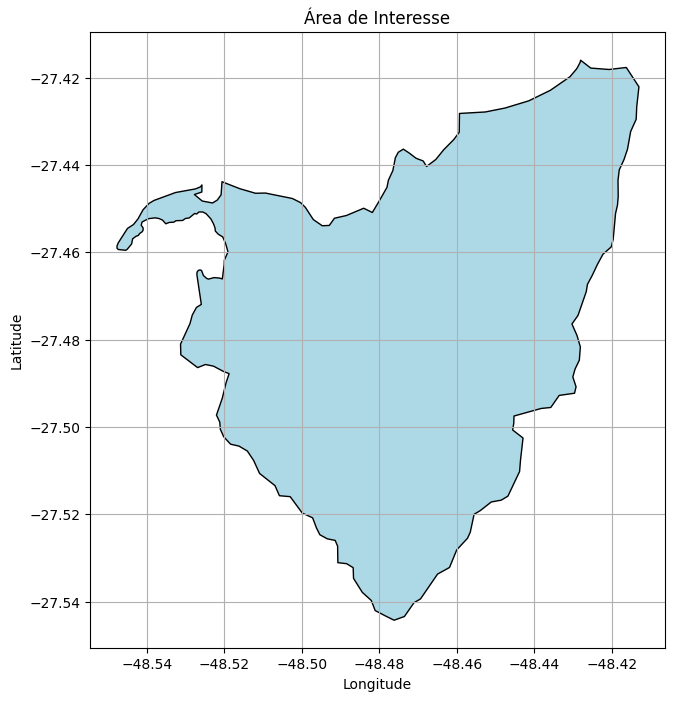

In [32]:
#Lendo shape com Geopandas
vector=gpd.read_file(shape)
#Reprojetando para a figura sair em sigas2000
# Reprojetar para o CRS desejado
vector_reprojected = vector.to_crs(epsg=4674)

# Plotar o shapefile reprojetado
fig, ax = plt.subplots(figsize=(10, 8))
vector_reprojected.plot(ax=ax, color='lightblue', edgecolor='black')

# Configurar os rótulos dos eixos
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Área de Interesse")
plt.grid(True)
output_file = f'../dados_solo/area_interesse_{ano}.jpg'
plt.savefig(output_file, format='jpeg', dpi=300)

In [33]:
# Garantir que o shapefile e o raster tenham o mesmo sistema de referência
with rasterio.open(usosolo) as src:
    if vector.crs != src.crs:
        vector = vector.to_crs(src.crs)
# Converter os polígonos do shapefile em um formato utilizável pelo Rasterio
geometries = [feature["geometry"] for feature in vector.__geo_interface__["features"]]

In [34]:
# Abrir o raster e aplicar o recorte
with rasterio.open(usosolo) as src:
    out_image, out_transform = mask(src, geometries, crop=True)
    out_meta = src.meta.copy()

In [35]:
# Atualizar os metadados do raster recortado
out_meta.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

In [36]:
# Salvar o raster recortado
rasterclip = r'../dados_solo/recortado_brasil_coverage_'+ano+'.tif'
with rasterio.open(rasterclip, "w", **out_meta) as dest:
    dest.write(out_image)

In [37]:
#Identificando os valores únicos de um raster
# Abrir o raster
with rasterio.open(rasterclip) as src:
    # Ler a primeira banda do raster
    raster_data = src.read(1)  # Supondo um raster de banda única

    # Obter os valores únicos e suas frequências
    unique_values, counts = np.unique(raster_data, return_counts=True) 
    
    # Criar um dicionário com o valor único e sua frequência
    frequency_dict = dict(zip(unique_values, counts))
    
    # Exibir a frequência de cada valor único
    for value, count in frequency_dict.items():
        print(f"Classe: {value}, Frequência: {count}")

Classe: 0, Frequência: 124945
Classe: 3, Frequência: 34063
Classe: 5, Frequência: 7509
Classe: 9, Frequência: 2792
Classe: 15, Frequência: 8161
Classe: 21, Frequência: 32313
Classe: 23, Frequência: 69
Classe: 24, Frequência: 10505
Classe: 25, Frequência: 67
Classe: 29, Frequência: 56
Classe: 32, Frequência: 1425
Classe: 33, Frequência: 1176
Classe: 41, Frequência: 94
Classe: 49, Frequência: 15802


In [38]:
#Lendo a legenda de uso do solo do MapBiomas
csv_path = r'../dados_solo/Codigos-da-legenda-colecao-9.csv'
# Ler o arquivo CSV
#Atenção, foi necessário corrigir o arquivo para entrada, removendo as virgulas nas linhas 31 e 35
df = pd.read_csv(csv_path, sep=';')
print(df.head())

#Transformando a minha legenda em um dicionário
legenda = dict(zip(df['Class_ID'], df['Description']))

   Class_ID  Level        Description           Descricao    Color
0         1      1             Forest            Floresta  #32a65e
1         3      2   Forest Formation  Formação Florestal  #1f8d49
2         4      2  Savanna Formation   Formação Savânica  #7dc975
3         5      2           Mangrove              Mangue  #04381d
4         6      2   Floodable Forest   Floresta Alagável  #026975


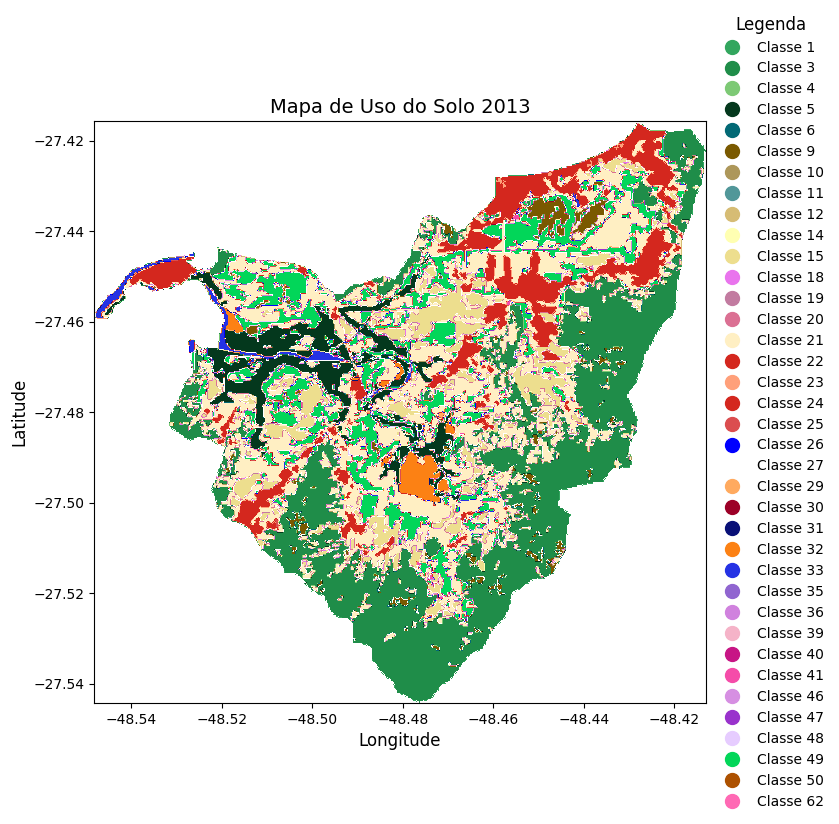

In [40]:
# Abrir o raster
dataset = rasterio.open(rasterclip)
raster_data = dataset.read(1)

# Obter os valores únicos do raster
unique_values = np.unique(raster_data)

# Criar um mapeamento de cores com base nos valores únicos
color_mapping = {
    'Class_ID': [1, 3, 4, 5, 6, 9, 10, 11, 12, 14, 15, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 35, 36, 39, 40, 41, 46, 47, 48, 49, 50, 62],  # Substituir pelos valores do raster
    'Color': ['#32a65e', '#1f8d49', '#7dc975', '#04381d', '#026975', '#7a5900', '#ad975a', '#519799', '#d6bc74', '#FFFFB2', '#edde8e', '#E974ED', '#C27BA0', '#db7093', '#ffefc3', '#d4271e', '#ffa07a', '#d4271e', '#db4d4f', '#0000FF', '#ffffff', '#ffaa5f', '#9c0027', '#091077', '#fc8114', '#2532e4', '#9065d0', '#d082de', '#f5b3c8', '#c71585', '#f54ca9', '#d68fe2', '#9932cc', '#e6ccff', '#02d659', '#ad5100', '#ff69b4']  

# Criar um array de cores para cada valor único no raster
color_array = ['white'] * (max(unique_values) + 1)  # Definir 'white' para valores sem correspondência
for class_id, color in zip(color_mapping['Class_ID'], color_mapping['Color']):
    if class_id < len(color_array):
        color_array[class_id] = color

# Criar o colormap
cmap = ListedColormap(color_array)

# Obter os limites do raster
transform = dataset.transform
x_min, y_max = transform * (0, 0)
x_max, y_min = transform * (dataset.width, dataset.height)

# Criar o gráfico
fig, ax = plt.subplots(figsize=(10, 8))
img = ax.imshow(raster_data, cmap=cmap, extent=(x_min, x_max, y_min, y_max))

# Adicionar título e rótulos dos eixos
ax.set_title(f'Mapa de Uso do Solo {ano}', fontsize=14)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Criar handles para a legenda
handles = [
    plt.Line2D([0], [0], marker='o', color=color, markersize=10, linestyle='', label=f"Classe {class_id}")
    for class_id, color in zip(color_mapping['Class_ID'], color_mapping['Color'])
]

# Adicionar a legenda fora da imagem
ax.legend(
    handles=handles,
    title="Legenda",
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    fontsize=10,
    title_fontsize=12,
    frameon=False
)

# Ajustar layout para evitar sobreposição
plt.tight_layout()

# Salvar o gráfico como um arquivo JPEG
output_file = f'../dados_solo/mapa_uso_solo_{ano}.jpg'
plt.savefig(output_file, format='jpeg', dpi=300)

# Mostrar o gráfico
plt.show()

In [41]:
#Calculando os percecntuais de área para cada classe
with rasterio.open(rasterclip) as dataset:
    # Ler os dados do raster
    band = dataset.read(1)  # Assumindo que é uma única banda (ou altere conforme necessário)
    
    # Filtrar os valores diferentes de 0
    band_filtered = band[band != 0]
    
    # Obter os valores únicos e suas frequências (desconsiderando 0)
    unique_values, counts = np.unique(band_filtered, return_counts=True)
    
    # Calcular o número total de pixels (desconsiderando 0)
    total_pixels = band_filtered.size
    
    # Criar um dicionário com os valores únicos e seus percentuais
    percentage_dict = {value: (count / total_pixels) * 100 for value, count in zip(unique_values, counts)}
    
    # Abrir um arquivo para salvar as informações
    informacoes=r'../dados_solo/informacoes_usosolo_'+ano+'.txt'
    with open(informacoes, "w") as file:
        # Escrever o cabeçalho
        file.write("Valor único,Classe,Percentual\n")    
        # Escrever as informações de cada valor único
        for value in unique_values:
            classe = legenda.get(value, "Classe Desconhecida")  # Pega a classe ou usa um valor padrão
            percentual = percentage_dict[value]
            file.write(f"{value:<12},{classe:<12},{percentual:.2f}%\n")
